# 1 - Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime


plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

# 2 - Loading the data and preprocessing

In [2]:
df = pd.read_excel('Assessment Data1.xlsx',sheet_name = 'Q1.Rev_Projection')
df.head()

,Time,Historical Revenue,Projected Revenue
0,Jan 20X1,2617639.0,NaN
1,Feb 20X1,2100614.0,NaN
2,Mar 20X1,2093397.0,NaN
3,Apr 20X1,1745256.0,NaN
4,May 20X1,1663300.0,NaN


Before analyzing historical data, it's recommended to set the index to pandas' datetime format. This makes querying and using other modules and functions more convenient. The data in the provided dataframe contains year values stored as '20X1' format, which implies the data spans from 2021 to 2023. To properly utilize the dataset, I performed necessary preprocessing steps, including formatting the year data to match the standard YYYY format and converting the index to pandas' datetime format. These adjustments help streamline subsequent analysis and ensure compatibility with time series analysis tools and techniques.

In [3]:
# Mapping of X1, X2, X3 to actual years
year_mapping = {
    '20X1': '2021',
    '20X2': '2022',
    '20X3': '2023',
    '20X4': '2024'
}

# Replace the '20X' part with the correct year
df['Time'] = df['Time'].replace(year_mapping, regex=True)
df=df.set_index(df['Time'])
df.index = pd.to_datetime(df.index,format='%b %Y')

#droping null values
df.drop(columns=['Time','Projected Revenue'],inplace=True)
df = df.dropna(axis=0)
df.head(10)

,Historical Revenue
Time,
2021-01-01,2617639.0
2021-02-01,2100614.0
2021-03-01,2093397.0
2021-04-01,1745256.0
2021-05-01,1663300.0
2021-06-01,1655221.0
2021-07-01,1714283.0
2021-08-01,1855538.0
2021-09-01,2466316.0


now that the dataframe is clean and ready to use, lets create a copy from it so that we can use it multiple times

In [4]:
df_orig= df.copy()

# 3 - EDA (Exploratory Data Analysis)

The plot offers a visual representation of the data and enables us to identify preliminary patterns, such as trends and seasonality. By inspecting the plot, we can gain valuable insights into the data's underlying properties, which can help inform our choices for further analysis, modeling, and forecasting techniques. Understanding the trends and seasonality in the data can also aid in identifying potential issues like outliers or data quality problems, and provide guidance for data preprocessing and cleaning steps. Ultimately, visualizing the data in this manner serves as a crucial first step in understanding the data and making informed decisions regarding its analysis.


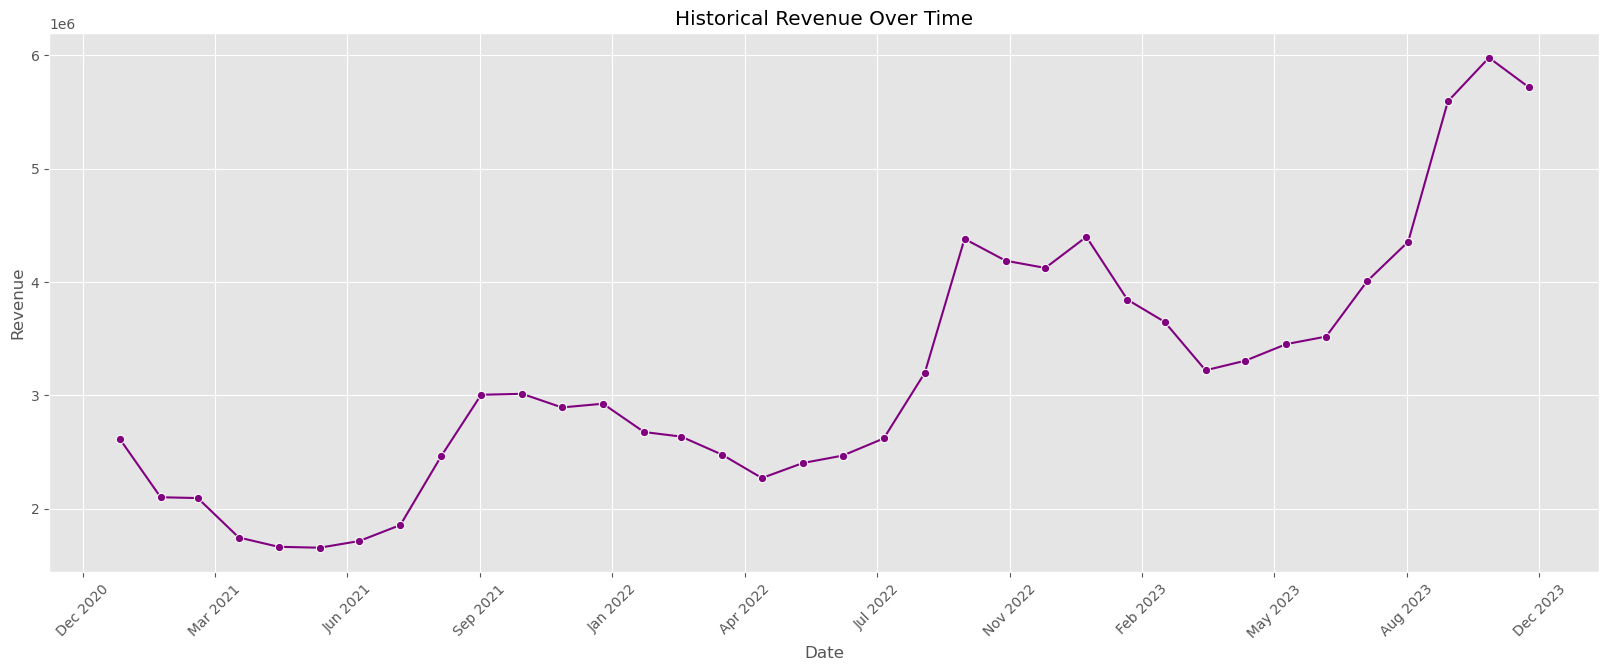

In [5]:
plt.figure(figsize=(20, 7))
sns.lineplot(data=df,x=df.index,y=df['Historical Revenue'],marker='o',color='purple')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Historical Revenue Over Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Show the plot
plt.show()

Observing the plot of historical revenue over time, it becomes evident that the data exhibits both a seasonal component and an upward trend. The recurring fluctuations in revenue values suggest a cyclical pattern, indicating the presence of seasonality in the data. This could be due to factors such as varying demand or sales throughout different periods of the year. Additionally, the overall upward progression in revenue values demonstrates a positive trend, which might be attributed to factors like market growth, increased customer base, or improved product offerings.

## 3 - 2 - Feature Creation

Using different timestamps, we can extract meaningful patterns from the data. for instance we can check for trends and seasonality based on months, or quarters.

In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df['month'] = df.index.month
    df ['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df

df = create_features(df)

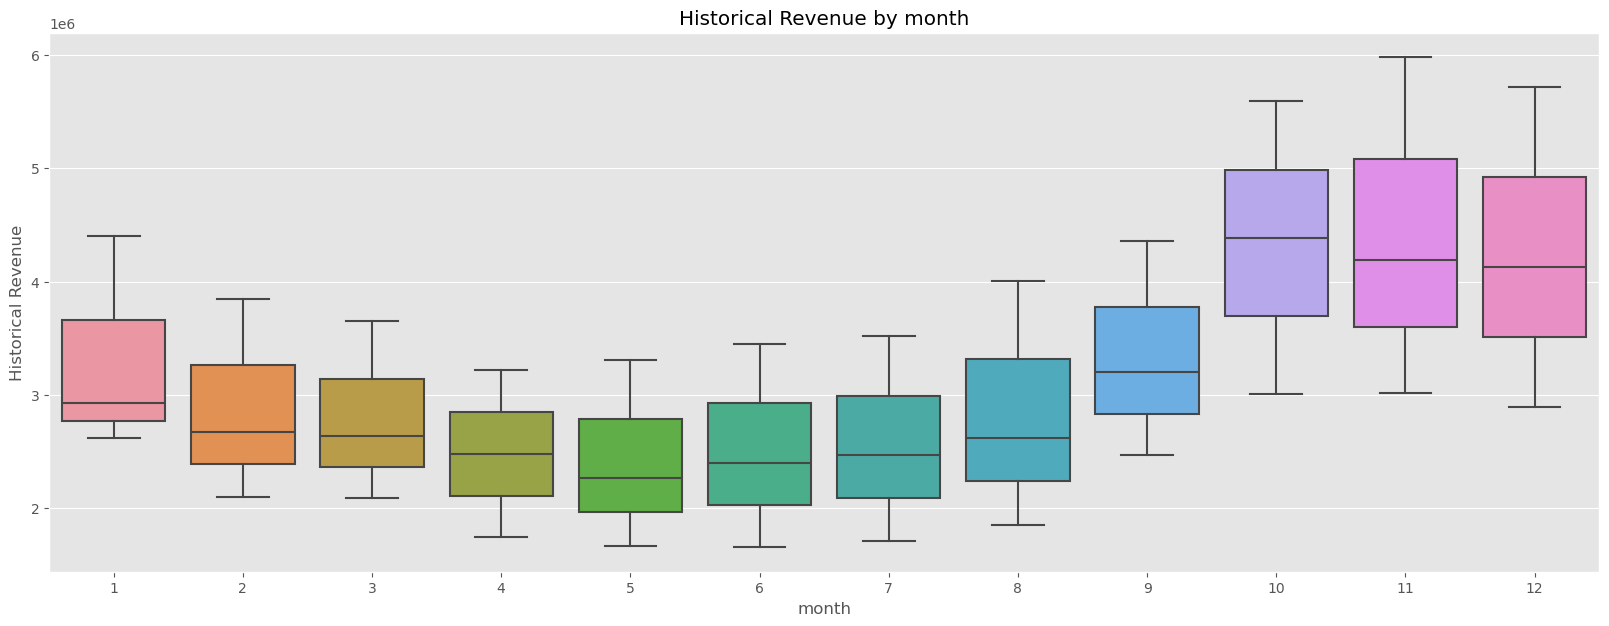

In [7]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df, x='month', y='Historical Revenue')
ax.set_title('Historical Revenue by month')
plt.show()

The boxplot reveals a yearly seasonal pattern spanning 12 months, with revenue tending to be lower during the months of April, May, and June. As the year progresses towards the holiday season, notably in the later months, we observe a gradual increase in revenue, reflecting higher demand and consumer spending during this period. As spring commences, the boxplot indicates a noticeable decrease in revenue, suggesting a potential correlation between the change in season and consumer spending habits. This observation could be influenced by factors such as seasonal preferences, budget constraints, or a shift in priorities that impact overall revenue during the early months of the year.The boxplot illustrates that the peak revenue occurs in November, highlighting the significance of this month in contributing to the annual sales. This peak can be attributed to the holiday shopping season and various promotional events, such as Black Friday and Cyber Monday, which stimulate consumer spending and drive revenue growth during this period.


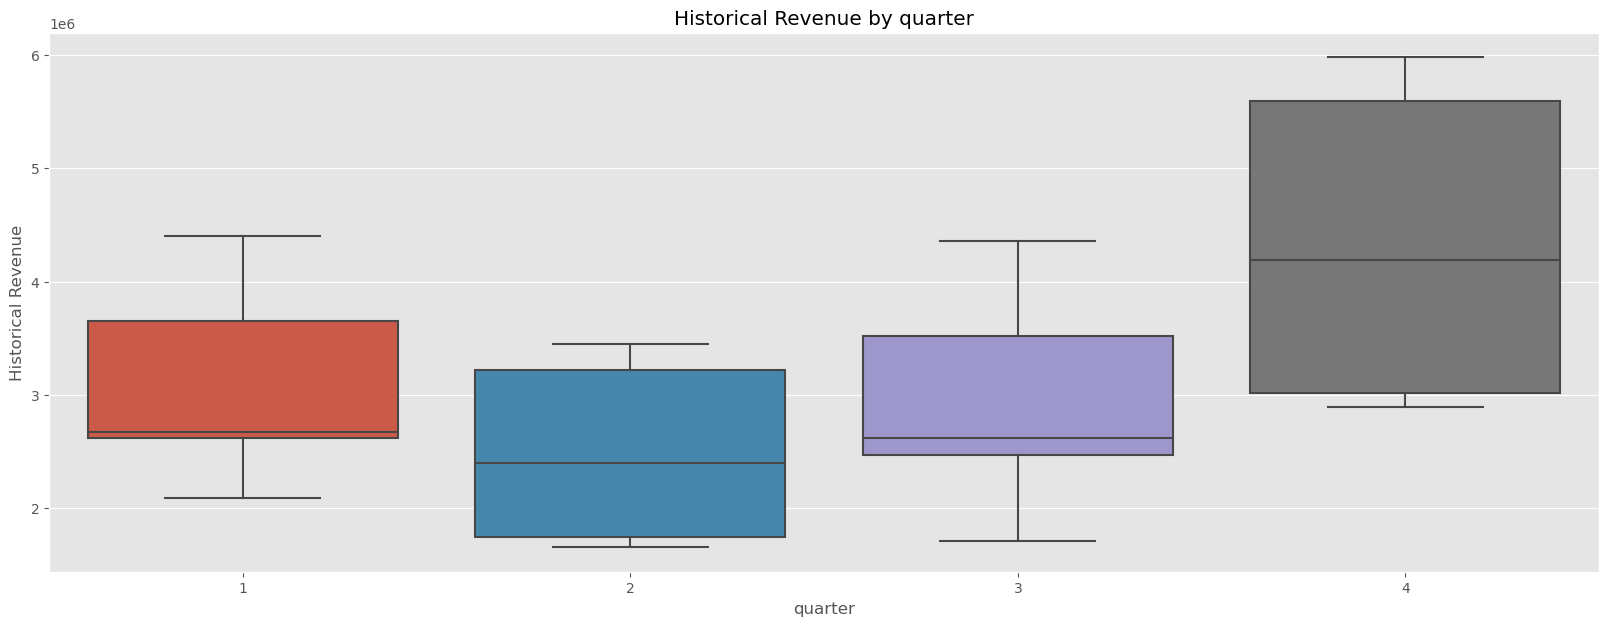

In [8]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df, x='quarter', y='Historical Revenue')
ax.set_title('Historical Revenue by quarter')
plt.show()

The boxplot for quarterly revenues unveils a pattern where the revenue reaches its pinnacle during the winter quarter. Notably, a decline in revenue is observed as we transition into the second quarter. This can be attributed to seasonal factors that influence consumer behavior and spending patterns, with peak shopping activities occurring during the winter holiday season followed by a subsequent decrease in the subsequent months.

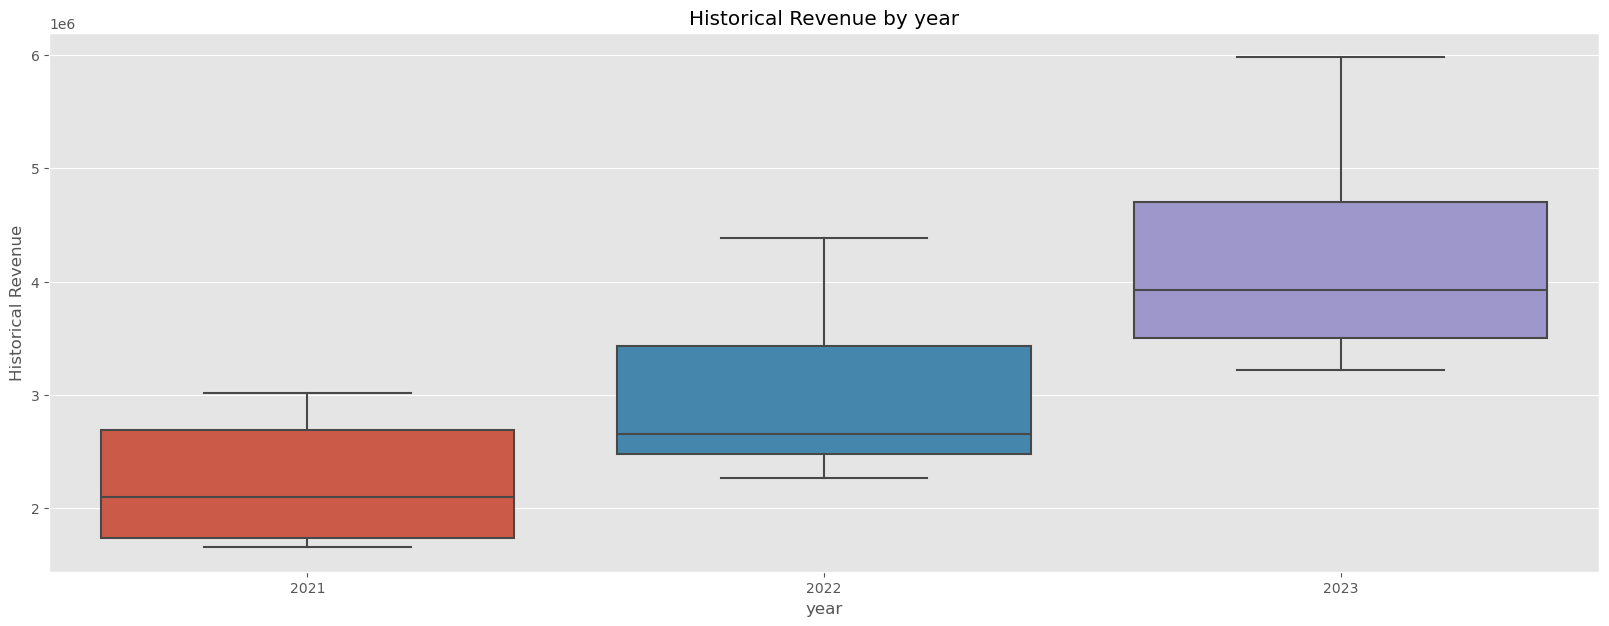

In [9]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df, x='year', y='Historical Revenue')
ax.set_title('Historical Revenue by year')
plt.show()

The yearly boxplot showcases a positive trend in Supply House's revenue growth, albeit with a limited dataset. This upward trend could signify the effectiveness of various business strategies implemented by the company, such as targeted marketing campaigns and well-executed pricing strategies. These initiatives may have resonated with customers and contributed to the consistent increase in revenue over the years.

# 4- Projection/Forecasting

Forecasting is the process of predicting future values based on historical data and trends. Three different methods used for forecasting in this analysis include:

**Linear Regression** - A statistical technique that models the relationship between a dependent variable (e.g., revenue) and one or more independent variables (e.g., time) by fitting a linear equation to the data.

**Exponential Smoothing** - A time series forecasting method that assigns exponentially decreasing weights as the observations get older. This technique effectively captures seasonality and trend patterns in the data by smoothing out irregularities (or noise) to better highlight genuine patterns.

**XGBoost** - A time series forecasting method that analyses historical data to identify patterns and relationships, taking into account trends, seasonality, It leverages gradient boosting to optimize models, making it highly effective for time series projections. 



## 4 - 1 - Linear Regression

Linear Regression is a simple yet powerful method that fits a straight line to the data points, aiming to minimize a distance metric (error, most of the time thiis distance metric is squared difference between estimated point and the original observed value) from each point to the line.

To make predictions, I first train the model using the first 36 data points. Once trained, the model can be used to estimate both the known values (estimated\_revenue) and future values (projected\_revenue) (via extrapolating the line). The linear equation derived during the training phase allows for straightforward calculations of future revenue based on the established trend.


### 4 - 1 - 1 - Creating the model and fitting the line

In [10]:
# importing the model from scikit-learn library
from sklearn.linear_model import LinearRegression

# the Linear regression model works with numbers as oppose to datetime format:
df['Time_in_days'] = (df.index - df.index.min()).days

# Separate the features (X) and target variable (y)
X = df[['Time_in_days']]
y = df['Historical Revenue']

# creating model instance, fitting the model 
model = LinearRegression()
model_fit=model.fit(X, y)

df['Estimated_Revenue'] = model.predict(X)

In [11]:
df.head()

,Historical Revenue,month,quarter,year,Time_in_days,Estimated_Revenue
Time,,,,,,
2021-01-01,2617639.0,1,1,2021,0,1.592848e+06
2021-02-01,2100614.0,2,1,2021,31,1.685031e+06
2021-03-01,2093397.0,3,1,2021,59,1.768293e+06
2021-04-01,1745256.0,4,2,2021,90,1.860477e+06
2021-05-01,1663300.0,5,2,2021,120,1.949687e+06


In [12]:
# Generate future dates for the next 12 months
future_dates = pd.date_range(df.index[-1] + pd.DateOffset(1), periods=12, freq='MS')

# Calculate the corresponding 'Time' values for these future dates
future_times = (future_dates - df.index.min()).days

# Create a DataFrame for the future projections
future_df = pd.DataFrame({'Time_in_days': future_times}, index=future_dates)

# Predict the revenue for the next 12 months
future_df['Projected_Revenue'] = model.predict(future_df[['Time_in_days']])

### 4 - 1 - 2 - Plotting the results

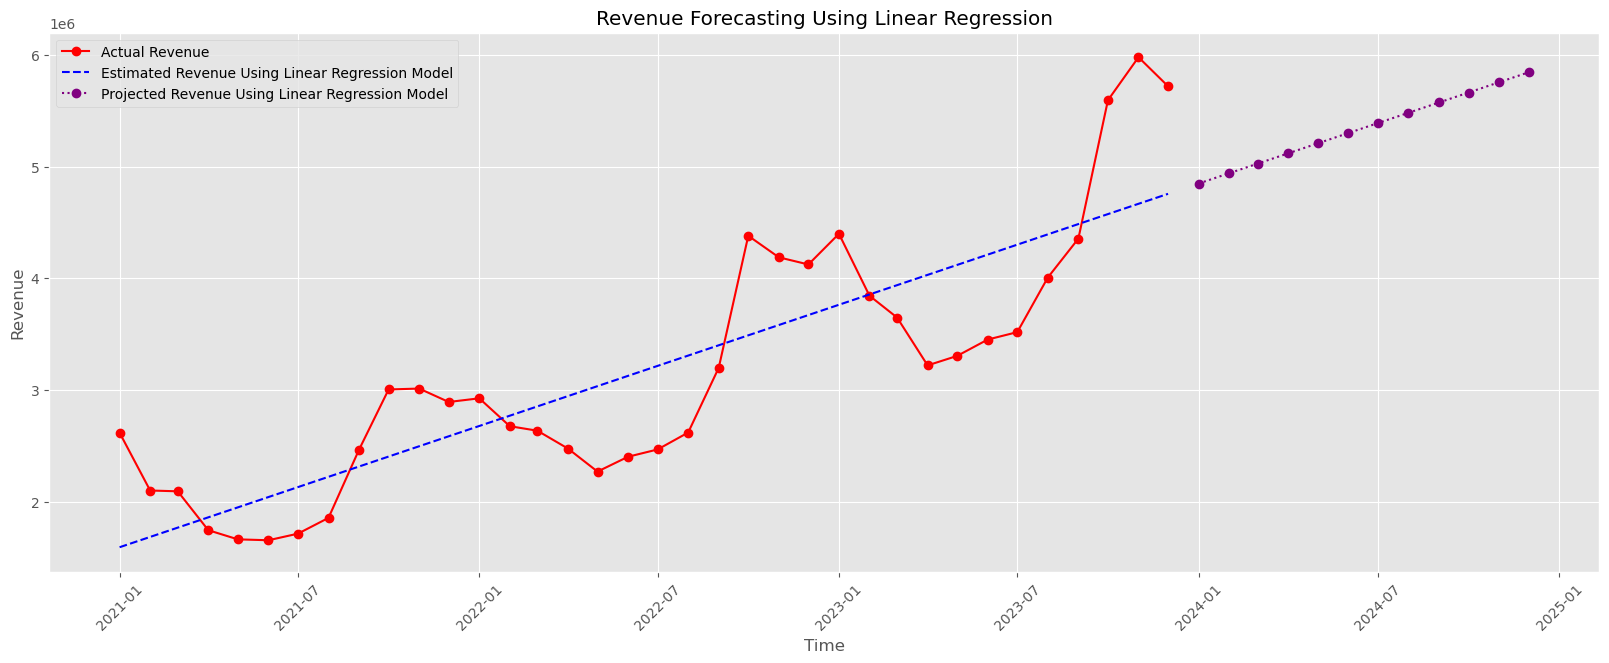

In [13]:
# Plot the original data, estimated values, and projections
plt.figure(figsize=(20, 7))
plt.plot(df.index, df['Historical Revenue'], color='red',label='Actual Revenue', marker='o')
plt.plot(df.index, df['Estimated_Revenue'], color="blue",label='Estimated Revenue Using Linear Regression Model', linestyle='--')
plt.plot(future_df.index, future_df['Projected_Revenue'],color="purple", label='Projected Revenue Using Linear Regression Model', linestyle=':', marker='o')
plt.title('Revenue Forecasting Using Linear Regression')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.show()


### 4 - 1 - 3 - Calculation and interpretation of metrics for the model

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y, df['Estimated_Revenue'])

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y, df['Estimated_Revenue'])

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared score
r2 = r2_score(y, df['Estimated_Revenue'])

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared score: {r2:.2f}")


Mean Absolute Error (MAE): 526078.32
Mean Squared Error (MSE): 371484354319.37
Root Mean Squared Error (RMSE): 609495.16
R-squared score: 0.70


These metrics help evaluate the performance of a linear regression model:

**Mean Absolute Error (MAE)**: This metric calculates the average absolute difference between the actual and predicted values. Here, an MAE of 526078.32 indicates that, on average, the model's predictions deviate from the actual values by approximately 526,078.32 units.

**Mean Squared Error (MSE)**: MSE represents the average squared difference between the actual and predicted values. A value of 371484354319.37 suggests a relatively large variance in the model's predictions, as the MSE is sensitive to outliers and large errors.

**Root Mean Squared Error (RMSE):** RMSE is the square root of MSE, making it in the same units as the original dataset. With an RMSE of 609495.16, we can deduce that the standard deviation of the model's residuals (errors) is roughly 609,495.16 units.

**R-squared score**: This metric measures the proportion of the variance in the dependent variable that can be explained by the independent variables in the model. A score of 0.70 implies that the linear regression model can account for 70% of the variance in the revenue data, suggesting a moderately good fit to the data.

In summary, the linear regression model exhibits moderate performance with some considerable errors. The model can explain a good portion of the variance in revenue data but may benefit from exploration of alternative forecasting methods to improve accuracy.

### 4 - 1 - 4 - Generating output

In [15]:
# Combine the original and future data
combined_LinearRegression = pd.concat([df, future_df])


#combined_LinearRegression.fillna(0,inplace=True)
#combined_LinearRegression['temp'] = combined_LinearRegression['Projected_Revenue'] + combined_LinearRegression['Estimated_Revenue']

#dropping unnecessary column:
#combined_LinearRegression.drop(columns = ['Projected_Revenue','Estimated_Revenue','Time_in_days'],inplace = True)
#combined_LinearRegression.rename(columns={'temp':'Projected_Revenue'},inplace=True)

In [16]:
combined_LinearRegression.head()

,Historical Revenue,month,quarter,year,Time_in_days,Estimated_Revenue,Projected_Revenue
2021-01-01,2617639.0,1.0,1.0,2021.0,0,1.592848e+06,NaN
2021-02-01,2100614.0,2.0,1.0,2021.0,31,1.685031e+06,NaN
2021-03-01,2093397.0,3.0,1.0,2021.0,59,1.768293e+06,NaN
2021-04-01,1745256.0,4.0,2.0,2021.0,90,1.860477e+06,NaN
2021-05-01,1663300.0,5.0,2.0,2021.0,120,1.949687e+06,NaN


In [17]:
combined_LinearRegression.to_csv('Linear_Regression.csv')

Now that the output is saved, lets bring out our original dataframe to use in the next section

In [18]:
df = df_orig.copy()

## 4 - 2 - Exponential Smoothing

In [19]:
df=df_orig.copy()
df.head()

,Historical Revenue
Time,
2021-01-01,2617639.0
2021-02-01,2100614.0
2021-03-01,2093397.0
2021-04-01,1745256.0
2021-05-01,1663300.0


In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [21]:
model = ExponentialSmoothing(df['Historical Revenue'], 
                             trend='additive',    # or 'multiplicative'
                             seasonal='multiplicative', # or 'multiplicative'
                             seasonal_periods=12) # adjust to your data's seasonality
fit = model.fit()

/home/amir/miniconda3/envs/eda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/amir/miniconda3/envs/eda/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [22]:
df['Estimated_Revenue'] = fit.fittedvalues

In [23]:
forecast = fit.forecast(steps=12)  # Forecast the next 12 periods

In [24]:
forecast=pd.DataFrame(forecast)

In [25]:
forecast=forecast.rename(columns={0:'Projected_Revenue'})

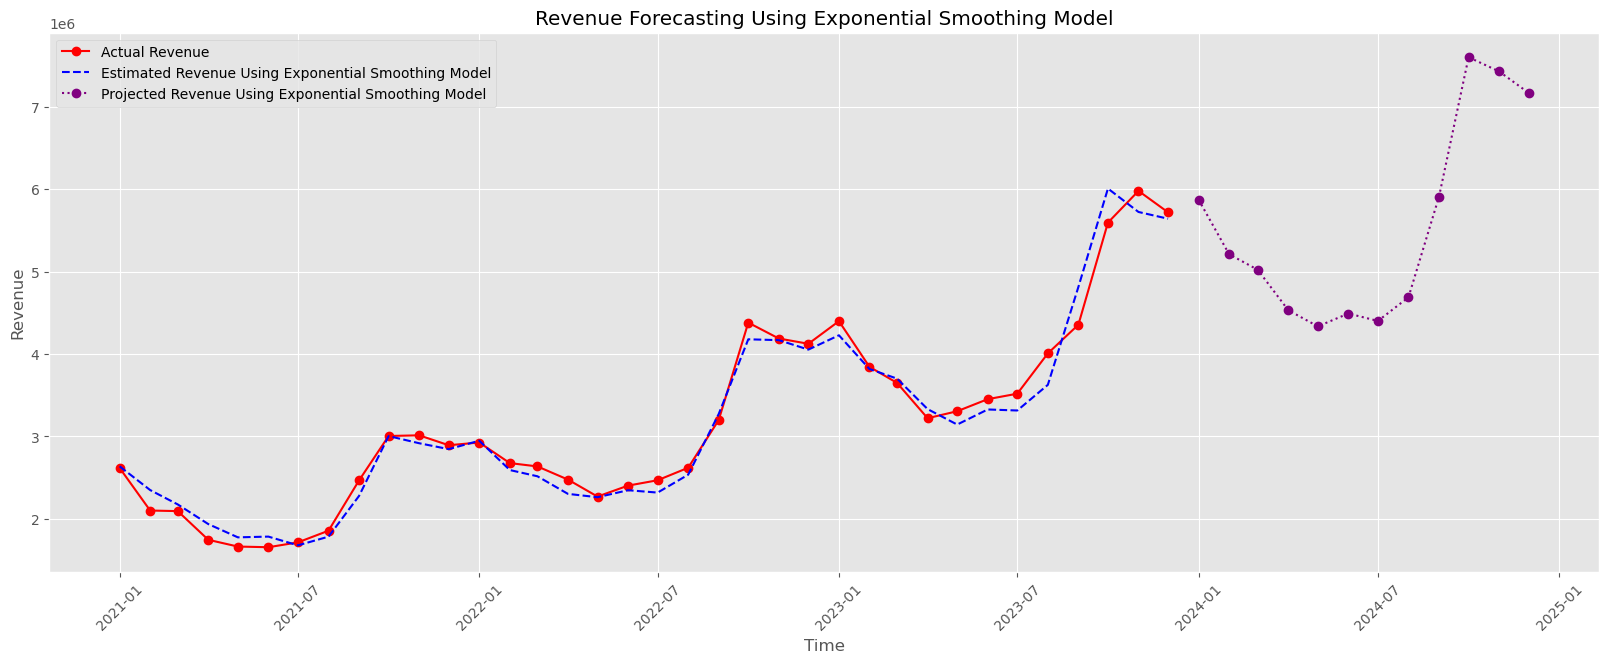

In [26]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(df.index, df['Historical Revenue'], color='red',label='Actual Revenue', marker='o')
plt.plot(df.index, df['Estimated_Revenue'], color="blue",label='Estimated Revenue Using Exponential Smoothing Model', linestyle='--')
plt.plot(future_df.index, forecast['Projected_Revenue'],color="purple", label='Projected Revenue Using Exponential Smoothing Model', linestyle=':', marker='o')
plt.title('Revenue Forecasting Using Exponential Smoothing Model')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [27]:
# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df['Historical Revenue'], df['Estimated_Revenue'])

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(df['Historical Revenue'], df['Estimated_Revenue'])

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared score
r2 = r2_score(df['Historical Revenue'], df['Estimated_Revenue'])

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared score: {r2:.2f}")

Mean Absolute Error (MAE): 131207.78
Mean Squared Error (MSE): 29184457982.03
Root Mean Squared Error (RMSE): 170834.59
R-squared score: 0.98


In [28]:
# Combine the original and future data
combined_ExponentialSmoothing = pd.concat([df, forecast])


In [29]:
combined_ExponentialSmoothing.head()

,Historical Revenue,Estimated_Revenue,Projected_Revenue
2021-01-01,2617639.0,2.637051e+06,NaN
2021-02-01,2100614.0,2.348983e+06,NaN
2021-03-01,2093397.0,2.174661e+06,NaN
2021-04-01,1745256.0,1.936124e+06,NaN
2021-05-01,1663300.0,1.775132e+06,NaN


In [30]:
combined_ExponentialSmoothing.to_csv('Exponential_Smoothing.csv')

In [31]:
df=df_orig.copy()

## 4 - 3 - XGBoost

XGBoost is a robust machine learning algorithm renowned for its powerful prediction capabilities. It leverages gradient boosting to optimize models, making it highly effective for time series projections. XGBoost's efficiency and advanced features enable accurate and reliable forecasting, making it a top choice for data scientists working with time-dependent tasks.

In [32]:
df.head()

,Historical Revenue
Time,
2021-01-01,2617639.0
2021-02-01,2100614.0
2021-03-01,2093397.0
2021-04-01,1745256.0
2021-05-01,1663300.0


### 4 - 3 - 1 - Test/Train Split

In [33]:
train = df.loc[df.index <= '06-01-2023']
test = df.loc[df.index >= '06-01-2023']

### 4 - 3 - 2 - Visualizing the test/train split

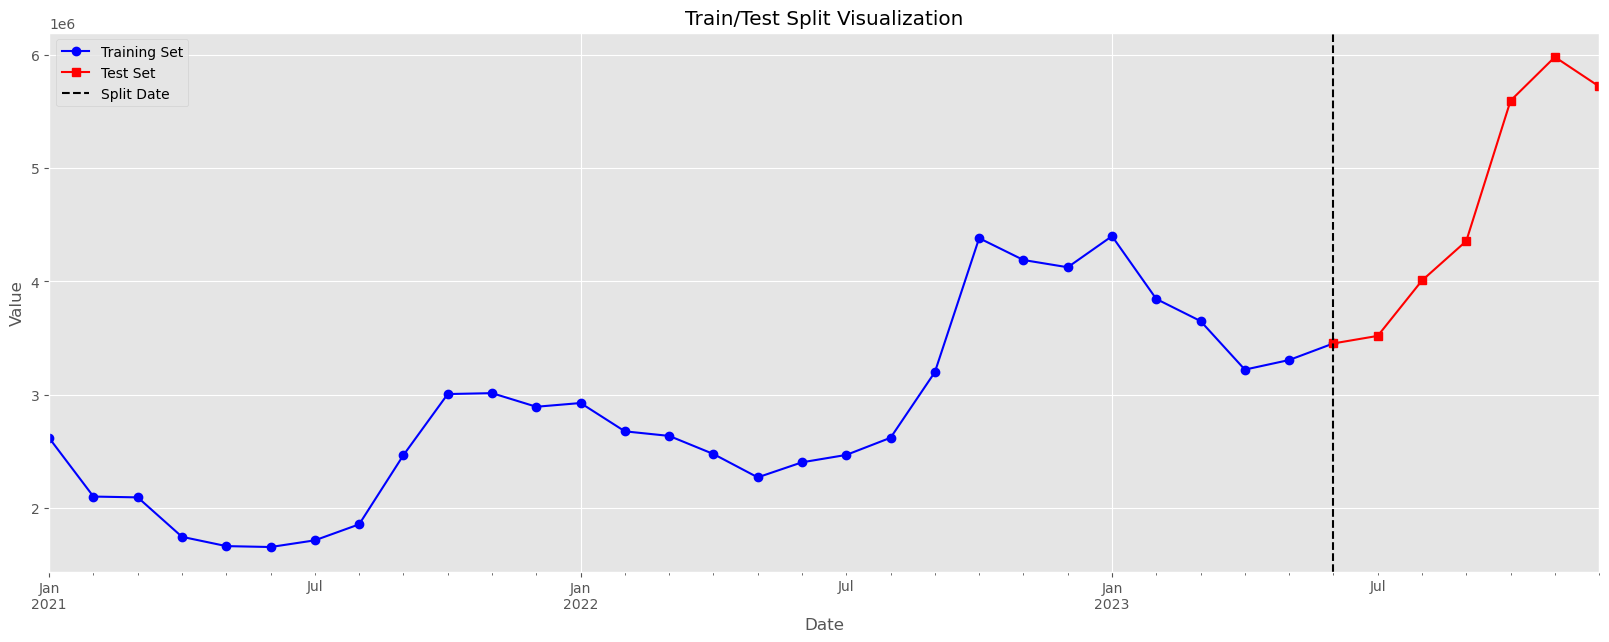

In [34]:
fig, ax = plt.subplots(figsize=(20, 7))
import matplotlib.pyplot as plt
# Plot training set (adjust column names and styling as needed)
train['Historical Revenue'].plot(ax=ax, label='Training Set', style='o-', color='blue')

# Plot test set (adjust column names and styling as needed)
test['Historical Revenue'].plot(ax=ax, label='Test Set', style='s-', color='red')
ax.axvline('06-01-2023', color='black', ls='--', label='Split Date')  # Use 'yyyy-mm-dd' format


ax.set_xlabel('Date')
ax.set_ylabel('Value')  # Replace with the actual variable you're plotting
ax.set_title('Train/Test Split Visualization')
# Add legend
ax.legend()
plt.show()

### 4 - 3 - 3 - Feature Extraction

Given the boxplots provided in section 2, we can determine that 3 features can be extracted from the dataset. Month, quarter and year.

In [35]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df['month'] = df.index.month
    df ['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df

df = create_features(df)

### 4 - 3 - 4 - Creating model

In [36]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [37]:
train = create_features(train)
test = create_features(test)
FEATURES = ['quarter', 'month', 'year']
TARGET = 'Historical Revenue'

In [38]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

### 4 - 3 - 5 - Fitting the model

In [39]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2920193.95623	validation_1-rmse:4737762.51769
[100]	validation_0-rmse:1244225.70954	validation_1-rmse:2757477.80291
[200]	validation_0-rmse:581132.00887	validation_1-rmse:1864773.47764
[300]	validation_0-rmse:294785.81285	validation_1-rmse:1441458.69240
[400]	validation_0-rmse:167875.42472	validation_1-rmse:1243966.55933
[500]	validation_0-rmse:108707.37749	validation_1-rmse:1154618.74364
[600]	validation_0-rmse:75375.80577	validation_1-rmse:1109266.79737
[700]	validation_0-rmse:58857.39270	validation_1-rmse:1087465.45349
[800]	validation_0-rmse:50633.23507	validation_1-rmse:1067334.30944
[900]	validation_0-rmse:45519.20801	validation_1-rmse:1053148.33390
[999]	validation_0-rmse:39964.18825	validation_1-rmse:1046411.03704


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### 4 - 3 - 6 - Visualizing feature importance 

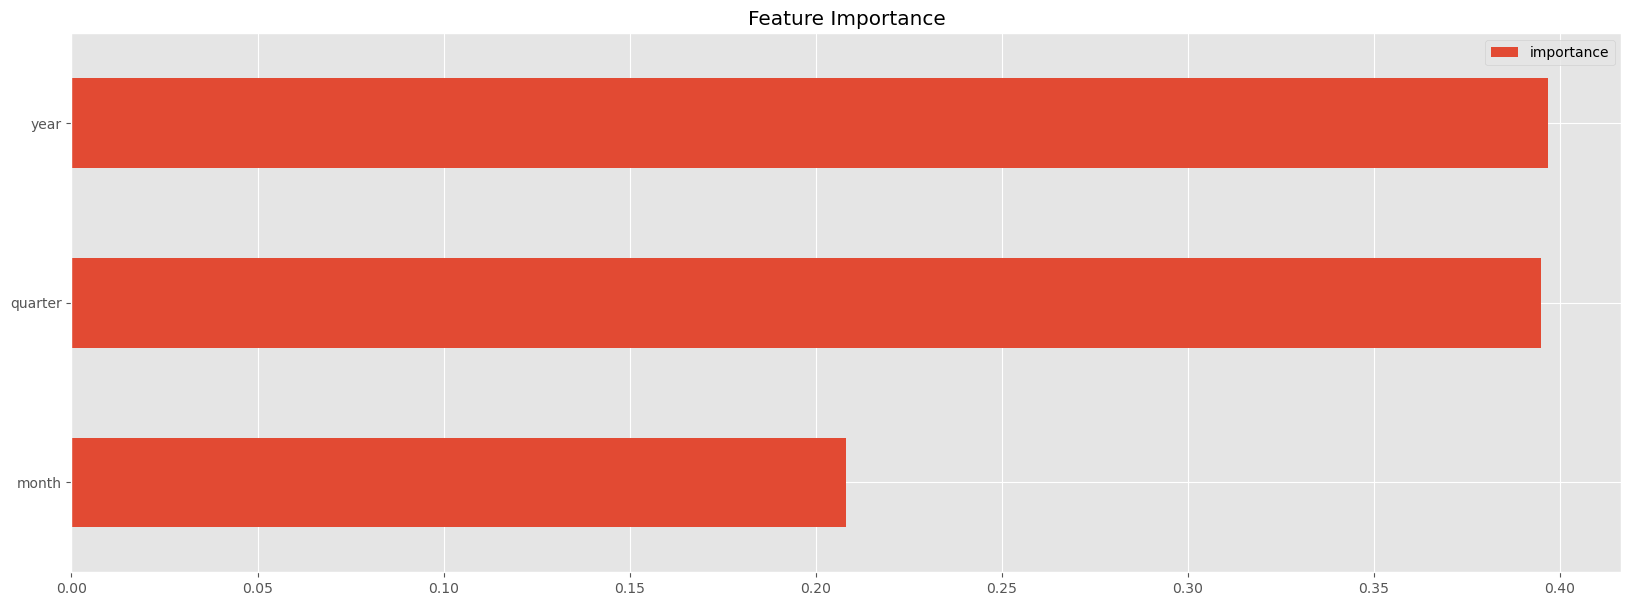

In [40]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance',figsize=(20,7))
plt.show()

### 4 - 3 - 7 - Making predictions

In [41]:
test['prediction'] = reg.predict(X_test)

In [49]:
X_test

,quarter,month,year
Time,,,
2023-06-01,2,6,2023
2023-07-01,3,7,2023
2023-08-01,3,8,2023
2023-09-01,3,9,2023
2023-10-01,4,10,2023
2023-11-01,4,11,2023
2023-12-01,4,12,2023


In [93]:
future_dates = pd.date_range(start='2024-01-01', end='2024-12-30', freq='MS')
future_data = pd.DataFrame({'Time': future_dates})

In [94]:
future_data.set_index('Time',inplace=True)

In [95]:
future_data['quarter'] = future_data.index.quarter
future_data['month'] = future_data.index.month
future_data['year'] = future_data.index.year

In [96]:
future_data['prediction'] = reg.predict(future_data)

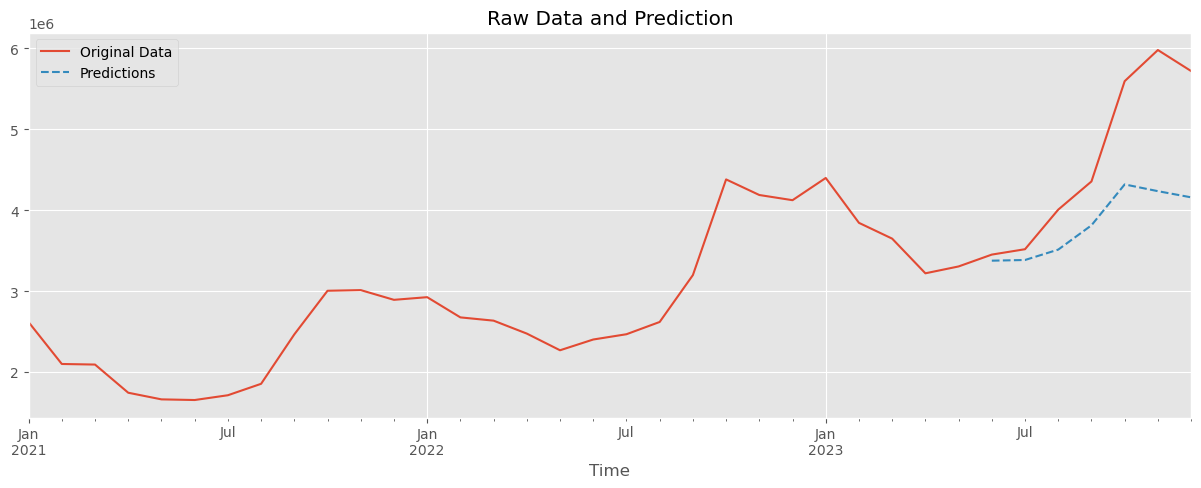

In [42]:

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Historical Revenue']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='--')
plt.legend(['Original Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [97]:
future_data.head(13)

,quarter,month,year,prediction
Time,,,,
2024-01-01,1,1,2024,4365675.00
2024-02-01,1,2,2024,3832195.75
2024-03-01,1,3,2024,3642927.50
2024-04-01,2,4,2024,3311707.50
2024-05-01,2,5,2024,3283432.00
2024-06-01,2,6,2024,3377003.75
2024-07-01,3,7,2024,3385490.25
2024-08-01,3,8,2024,3513835.25
2024-09-01,3,9,2024,3813924.25


In [98]:
df.head()

,Historical Revenue,month,quarter,year,prediction
Time,,,,,
2021-01-01,2617639.0,1,1,2021,NaN
2021-02-01,2100614.0,2,1,2021,NaN
2021-03-01,2093397.0,3,1,2021,NaN
2021-04-01,1745256.0,4,2,2021,NaN
2021-05-01,1663300.0,5,2,2021,NaN


In [99]:
combined_df = pd.concat([df,future_data])

In [100]:
combined_df

,Historical Revenue,month,quarter,year,prediction
Time,,,,,
2021-01-01,2617639.0,1,1,2021,NaN
2021-02-01,2100614.0,2,1,2021,NaN
2021-03-01,2093397.0,3,1,2021,NaN
2021-04-01,1745256.0,4,2,2021,NaN
2021-05-01,1663300.0,5,2,2021,NaN
2021-06-01,1655221.0,6,2,2021,NaN
2021-07-01,1714283.0,7,3,2021,NaN
2021-08-01,1855538.0,8,3,2021,NaN
2021-09-01,2466316.0,9,3,2021,NaN


In [43]:
combined_df.to_csv('XGBoost.csv')

### 4 - 3 - 8 - Checking model scores

In [44]:
score = np.sqrt(mean_squared_error(test['Historical Revenue'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1046411.04


In [45]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-11-01    1743942.00
2023-12-01    1560483.50
2023-10-01    1275665.00
2023-09-01     542009.75
2023-08-01     493868.75
2023-07-01     133151.75
2023-06-01      75223.25
Name: error, dtype: float64

# 5 - Conclusion

In this notebook, I analyzed monthly revenue data and projected future revenue using three distinct methods:

**Least Square Linear Regression:** 

This simple method captured the increasing trend in average revenue but struggled with capturing seasonality, resulting in significant errors.

**Exponential Smoothing:** 
A straightforward yet effective technique that successfully accounted for both trend and seasonality, yielding the smallest errors among the three methods.

**XGBoost:**
Although this powerful machine learning algorithm is ideal for time series analysis and projections, its performance relies on larger datasets. Consequently, with a limited dataset like this one, the results were not as satisfactory as expected.

For future projections, given a larger dataset, an ARIMA model could be considered, as it is another potent forecasting method often used in revenue projection. However, our data is non-stationary, necessitating transformations like differencing and logarithmic scaling. These transformations further reduce the dataset size, potentially limiting the model's performance.